In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [2]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results, load_single_result
from io_utils import save_data_to_file
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results_our_lm")
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(res_dir, 'entero_data', 'results_our_lm', '{}_{}'.format(method, mtype))
os.makedirs(ddir, exist_ok=True)

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


In [3]:
result = load_single_result(RDIR, method, mtype)
n_rej = len(result['rejections'])
n_genes = len(result['p_vals'])
print('Number of rejections: {} ({:.2f}%)'.format(n_rej, n_rej / n_genes * 100))

Number of rejections: 7274 (75.33%)


# Fit the curve on all genes

In [4]:
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin, norm_mtx
# get the variable group ids
mtx = norm_mtx(mtx)
lam = result["lam_update"]
base_args = setup_basis(lam, n_knots=10)
print(base_args)
p_fun, c_mtx = spline_fit(lam, mtx, base_args)

cr(x, knots=(-0.059, -0.05, -0.041, -0.032, -0.023, -0.014, -0.005, 0.004, 0.013, 0.022))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters
Fitted 9000 parameters


In [5]:
from main_methods import refit_curves
print(c_mtx.shape)
x_vals, fit_mtx = refit_curves(c_mtx, base_args, lam)

[feat_viz INFO] Fitted points stored in (50, 9656)


(9656, 13)


# Remove low variance genes 

In [6]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


In [7]:
from intestine_info import load_gene_set_clusters
from plot_utils import plot_venn
# use the cutoff to select genes to further cluster
def select_variable_genes(result, var_df, cut_off = 0.5):
    sel = var_df['std'] > cut_off
    high_var_idx = var_df.loc[sel].index.values
    cor_sel_idx = result['rejections']
    int_size = set(high_var_idx).intersection(set(cor_sel_idx))
    print('{} out of {} are spatial varying'.format(len(int_size), len(high_var_idx)))
    kmtx, kdf = load_gene_set_clusters(var_df)
    gset = {}
    gset['moor_sel'] = set(kdf.index)
    gset['high_var'] = set(var_df.loc[sel]['gene_ids'])
    gset['space_var'] = set(var_df.loc[result['rejections']]['gene_ids'])
    use_df = var_df.loc[sel]
    use_df = use_df.loc[use_df.index.isin(result['rejections'])]
    ndf = kdf.loc[kdf['orig_idx'].isin(use_df.index)]
    vals = pd.Series(-1*np.ones(use_df.shape[0]), index=use_df.index).astype(int)
    vals[ndf['orig_idx']] = ndf['clust_idx']
    use_df['moor_clust'] = vals
    gset['our_sel'] = set(use_df['gene_ids'])
    print('Final set used for clustering: {}'.format(use_df.shape[0]))
    return use_df, gset
use_df, gset =  select_variable_genes(result, var_df)
use_df.head()

1920 out of 1981 are spatial varying
Final set used for clustering: 1920


,gene_ids,n_cells,mean,std,npc,moor_clust
0,Mrpl15,530,0.386412,0.530710,530,1
1,Lypla1,1045,0.999767,0.698513,1045,3
14,Arfgef1,732,0.559252,0.594950,732,3
16,Tram1,707,0.536192,0.579412,707,1
20,Rpl7,1009,1.524548,1.203265,1009,4


Retaining genes: 1920


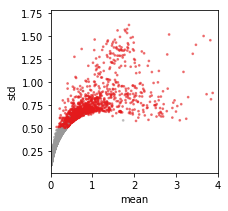

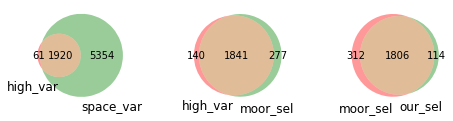

[feat_viz INFO] Saved figure to: /scratch/PI/sabatti/spatial_subplots/intestine_var_sv_venn.pdf


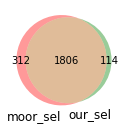

In [8]:
sel_or_not = (var_df.index.isin(use_df.index))
print('Retaining genes: {}'.format(np.sum(sel_or_not)))
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(var_df['mean'], var_df['std'], c=sel_or_not*-1, 
           s=3, cmap='Set1', alpha =0.5)
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.set_xlim(0, 4)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(8, 1.8))
plot_venn(gset, ['high_var', 'space_var'], ax=axes[0])
plot_venn(gset, ['high_var', 'moor_sel'], ax=axes[1])
plot_venn(gset, ['moor_sel', 'our_sel'], ax=axes[2])
plt.show()


fdir = '/scratch/PI/sabatti/spatial_subplots/'
fn = fdir + 'intestine_var_sv_venn.pdf'
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_venn(gset, ['moor_sel', 'our_sel'], ax=ax, fn=fn)
plt.show()

# Run the gene clustering pipeline

In [9]:
# our pipeline
import umap
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

uobj = umap.UMAP(random_state=1010)
u_mtx = c_mtx[use_df.index, :]
print("input dimension: {}".format(u_mtx.shape))
embedding = uobj.fit_transform(u_mtx)

input dimension: (1920, 13)


In [10]:
from main_methods import graph_spectrum, graph_clustering
evals, evecs = graph_spectrum(uobj.graph_)
optimal_kvals = np.argsort(np.diff(evals))[::-1]
print(optimal_kvals)

[15  9 13  6  7  2  8 14 12 16  0 18  1 17  4 11  5  3 10]


In [29]:
k_vals = optimal_kvals[:4] 
kids = ['k_{}'.format(k) for k in k_vals] 
clust_df = graph_clustering(evecs, k_vals)
# merge
mdf = use_df.reset_index().rename(columns={'index': 'orig_idx'})
mdf = mdf.join(clust_df)
mdf = mdf.set_index('gene_ids')
mdf['umap 1'] = embedding[:, 0]
mdf['umap 2'] = embedding[:, 1]
kmtx, kdf = load_gene_set_clusters(var_df)
int_df = kdf.join(mdf.drop('orig_idx', axis=1), how='inner')
print(int_df.shape)
int_df.head()
assert np.array_equal(int_df['clust_idx'], int_df['moor_clust']), 'moor clust mismatch'
display(int_df.head())

(1806, 15)


,indin,clust_idx,curr_idx,orig_idx,n_cells,mean,std,npc,moor_clust,k_15,k_9,k_13,k_6,umap 1,umap 2
Mrpl15,8,1,0,0,530,0.386412,0.530710,530,1,11,1,5,2,3.278846,1.190773
Lypla1,9,3,1,1,1045,0.999767,0.698513,1045,3,4,5,3,4,-0.974191,1.133437
Arfgef1,40,3,2,14,732,0.559252,0.594950,732,3,3,0,0,2,0.333336,0.013566
Tram1,52,1,3,16,707,0.536192,0.579412,707,1,3,0,0,2,1.419247,-0.270409
Rpl7,63,4,4,20,1009,1.524548,1.203265,1009,4,13,2,7,1,8.094422,1.513515


In [30]:
# compute embedding from moor zonation
from main_methods import compute_embedding
moor_embed = compute_embedding(kmtx[int_df['curr_idx'], :])

input dimension: (1806, 7)


In [31]:
cmp_dict = {
    'moor': {
        'x': np.arange(kmtx.shape[1]),
        'mtx': kmtx.T,
        'idx': 'curr_idx',
        'embedding': moor_embed
    },
    'ours': {
        'x': x_vals,
        'mtx': fit_mtx,
        'idx': 'orig_idx',
        'embedding': embedding
    }
}

fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'viz_dict': os.path.join(ddir, 'viz_dict.pkl'),
    'gene_clust_df': os.path.join(ddir, 'gene_clust_df.csv'),
    'moor_clust_df': os.path.join(ddir, 'moor_clust_df.csv'),
    'use_df': os.path.join(ddir, 'use_df.csv')
}
save_data_to_file(result, fns['result'], 'pkl')
save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')
save_data_to_file(cmp_dict, fns['viz_dict'], 'pkl')
save_data_to_file(clust_df, fns['gene_clust_df'], 'csv')
save_data_to_file(int_df, fns['moor_clust_df'], 'csv')
save_data_to_file(use_df, fns['use_df'], 'csv')